In [1]:
# Credits to twitter.com/F1DataAnalysis
import fastf1 as ff1
from fastf1 import plotting
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Setup 
ff1.Cache.enable_cache("CacheFormulaOne")
plotting.setup_mpl()

In [3]:
# Load session: Abu Dhabi 2022, Qualyfing
session = ff1.get_session(2022, "Abu Dhabi", "Q")
session.load()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '44', '63', '4', '31', '5', '3', '14', '22', '47', '18', '24', '20', '10', '77', '23', '6']


In [4]:
# Select fastest lap from Verstappen (Pole position)
driver = "VER"
fl = session.laps.pick_driver(driver).pick_fastest()
fl_telemetry = fl.get_telemetry().add_distance()

In [5]:
# Compute speed and time
v = fl_telemetry["Speed"] / 3.6
t = fl_telemetry["Time"] / np.timedelta64(1, "s") # Change format (Date -> number)

# Compute longitudinal acceleration
ax = np.gradient(v) / np.gradient(t) # Take variation of both speed and time
ax_smooth = np.convolve(ax, np.ones(3,) / 3, mode = "same") # Smooth accerlation

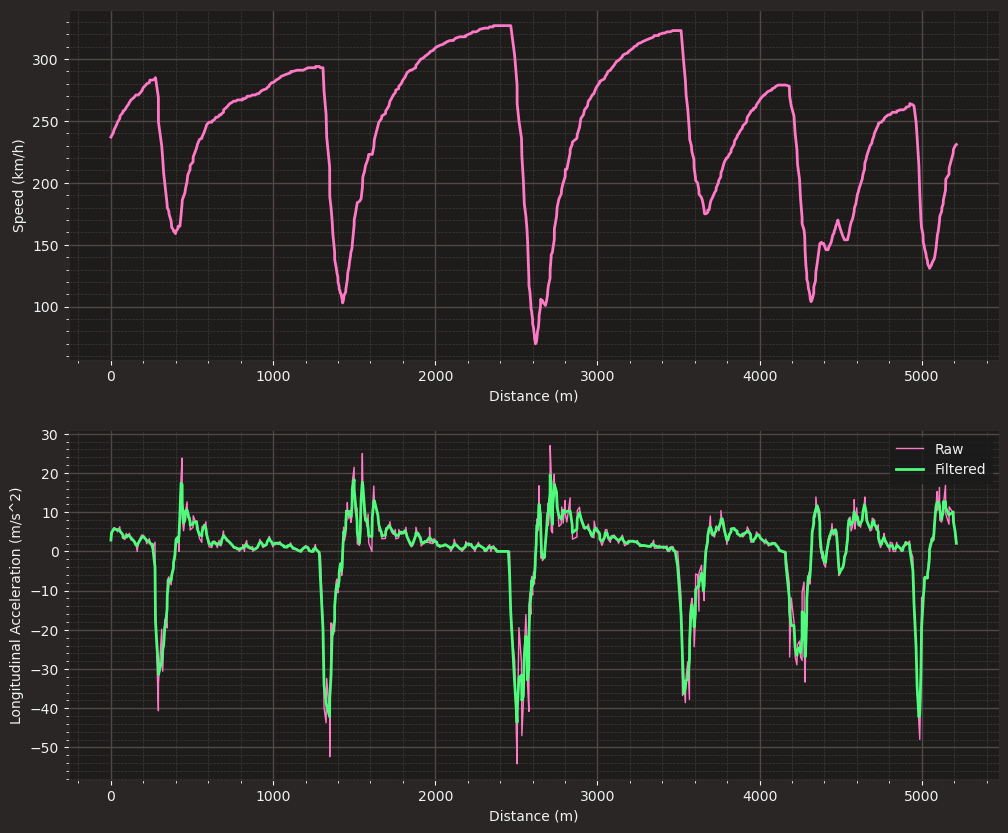

In [6]:
# Plot speed and longitudinal Acceleration
figure, axes = plt.subplots(2, 1, figsize=(12, 10))

# Speed
axes[0].plot(fl_telemetry["Distance"], fl_telemetry["Speed"], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

# Acceleration (Raw and filtered)
axes[1].plot(fl_telemetry["Distance"], ax, linewidth = 1, label = "Raw")
axes[1].plot(fl_telemetry["Distance"], ax_smooth, linewidth = 2, label = "Filtered")
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")
axes[1].legend()

In [7]:
# Create 1st model: Static weight only
m = 798 # kg
g = 9.81

static_weight_total = m * g
weight_front_fraction = 0.46

# Compute weights for front and rear
static_weight_front = static_weight_total * weight_front_fraction
static_weight_rear = static_weight_total - static_weight_front

# Front and rear model (Convert weights into time signals)
static_model_load_front = [static_weight_front] * len(fl_telemetry["Distance"])
static_model_load_rear = [static_weight_rear] * len(fl_telemetry["Distance"])

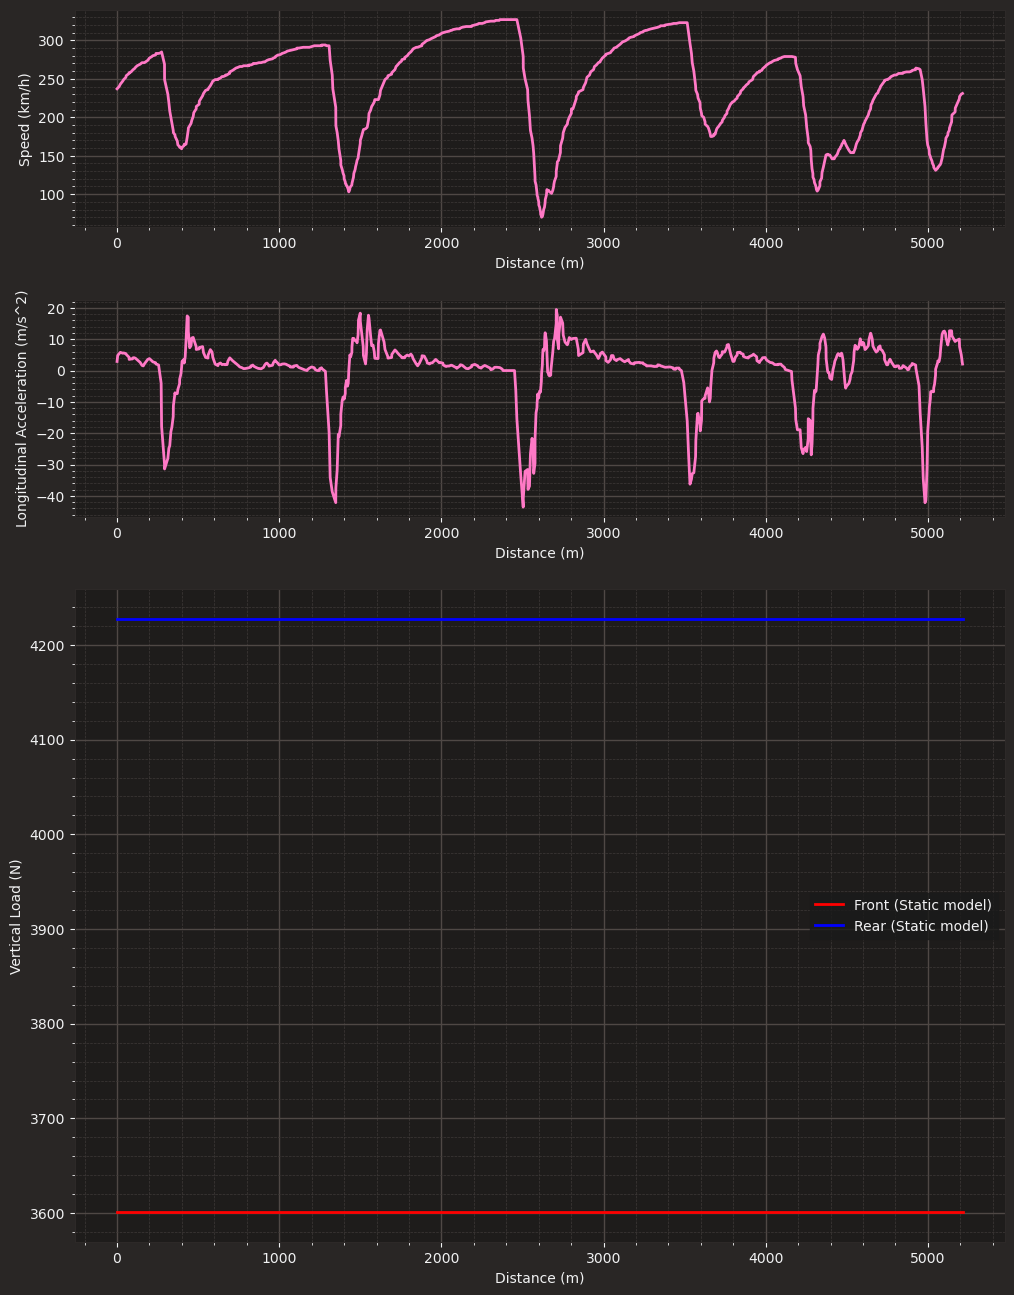

In [8]:
# Plot 1st model
plot_ratios = [1, 1, 3]

figure, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw = {"height_ratios": plot_ratios})

# Speed
axes[0].plot(fl_telemetry["Distance"], fl_telemetry["Speed"], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

# Acceleration
axes[1].plot(fl_telemetry["Distance"], ax_smooth, linewidth = 2, label = "Filtered")
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

# Vertical load
axes[2].plot(fl_telemetry["Distance"], static_model_load_front, "r", linewidth = 2, label = "Front (Static model)")
axes[2].plot(fl_telemetry["Distance"], static_model_load_rear, "b", linewidth = 2, label = "Rear (Static model)")
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [9]:
# Create 2nd model: Intertial load transfer added
cog_height = 0.25 # m, Center of gravity
wheelbase = 3.6 # m, distance between axles

delta_load_intertia = - cog_height / wheelbase * m * ax_smooth # delta < 0 -> Positive acceleration (Load shifts to the rear)

# Front and rear model
Intertial_model_load_front = static_weight_front + delta_load_intertia
Intertial_model_load_rear = static_weight_rear - delta_load_intertia

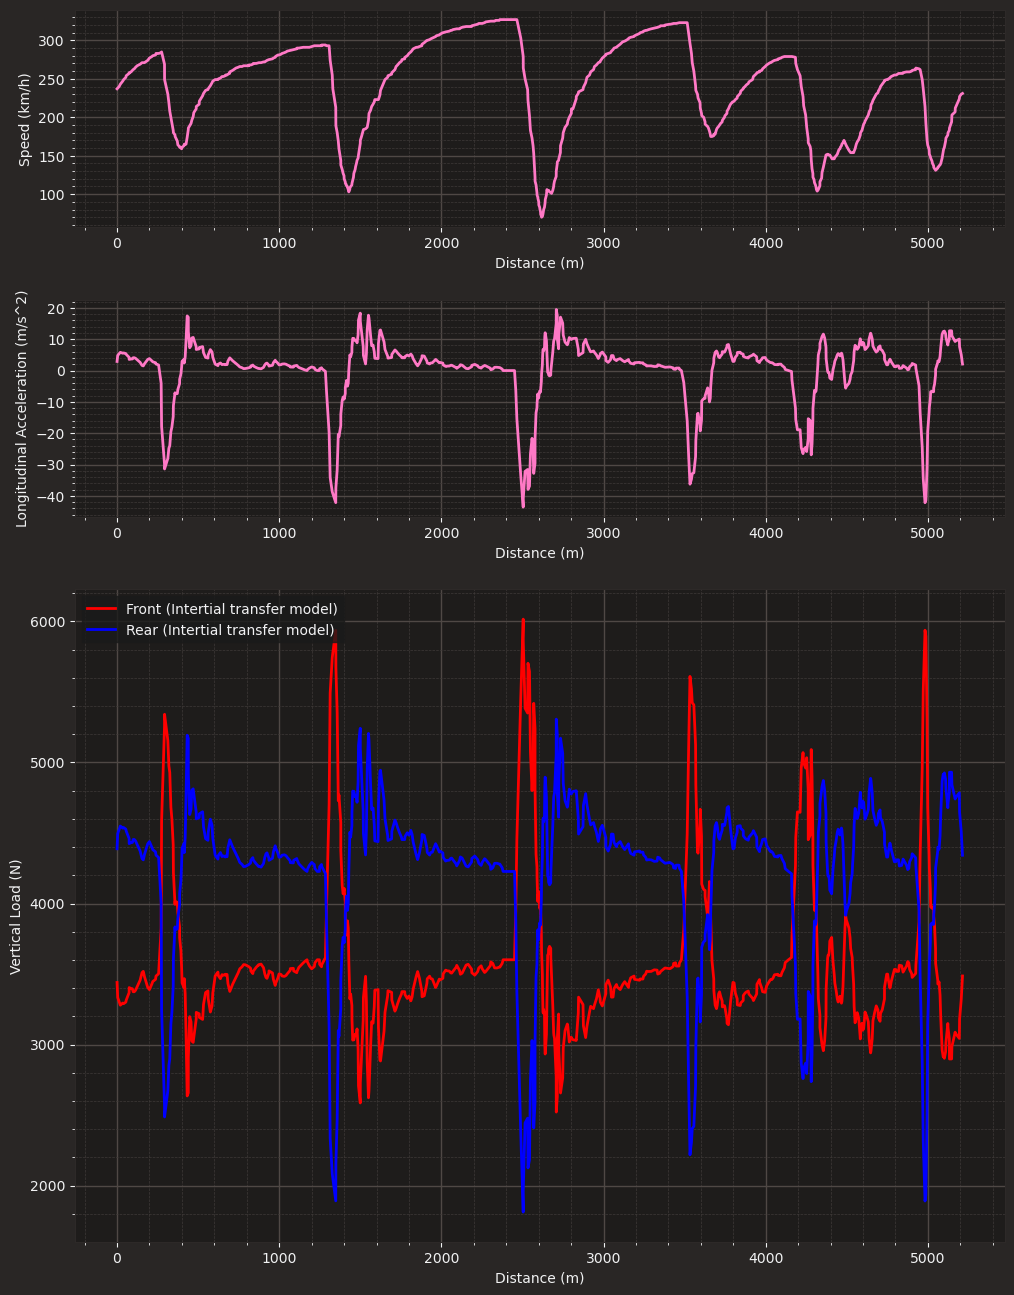

In [10]:
# Plot 2nd model
figure, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw = {"height_ratios": plot_ratios})

# Speed
axes[0].plot(fl_telemetry["Distance"], fl_telemetry["Speed"], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

# Acceleration
axes[1].plot(fl_telemetry["Distance"], ax_smooth, linewidth = 2, label = "Filtered")
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

# Vertical load
axes[2].plot(fl_telemetry["Distance"], Intertial_model_load_front, "r", linewidth = 2, label = "Front (Intertial transfer model)")
axes[2].plot(fl_telemetry["Distance"], Intertial_model_load_rear, "b", linewidth = 2, label = "Rear (Intertial transfer model)")
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [11]:
# Create 3rd model: Drag and downforce added
air_density = 1.225
aero_efficiency = 3.7 # downforce-to-drag ratio
drag_height = 0.5 # Height at which drage force is applied
fraction_downforce_front = 0.4 # Front downforce as fraction of total downforce (Aero balance)

CdA = 1.7 # Drag cofficient multiplied with frontal area
ClA = aero_efficiency * CdA # Downforce cofficient multiplied with aerodynamic efficiency

# Compute drag and downforce
drag = 0.5 * CdA * air_density * np.square(v)
delta_load_drag = - drag_height / wheelbase * drag # Always negative: Drag shifts load from front to rear

downforce = 0.5 * ClA * air_density * np.square(v)
downforce_front = fraction_downforce_front * downforce
downforce_rear = (1 - fraction_downforce_front) * downforce

# Front and rear model
aero_model_load_front = Intertial_model_load_front + downforce_front + delta_load_drag
aero_model_load_rear = Intertial_model_load_rear + downforce_rear - delta_load_drag

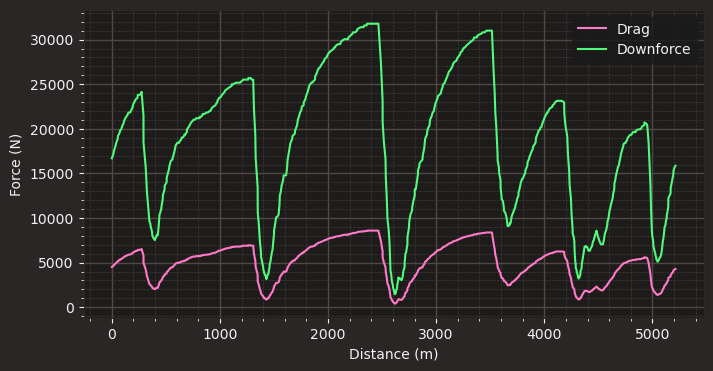

In [12]:
# Plot drag and total downforce
figure, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(fl_telemetry["Distance"], drag, label = "Drag")
ax.plot(fl_telemetry["Distance"], downforce, label = "Downforce")
ax.set(xlabel = "Distance (m)", ylabel = "Force (N)")
ax.legend()

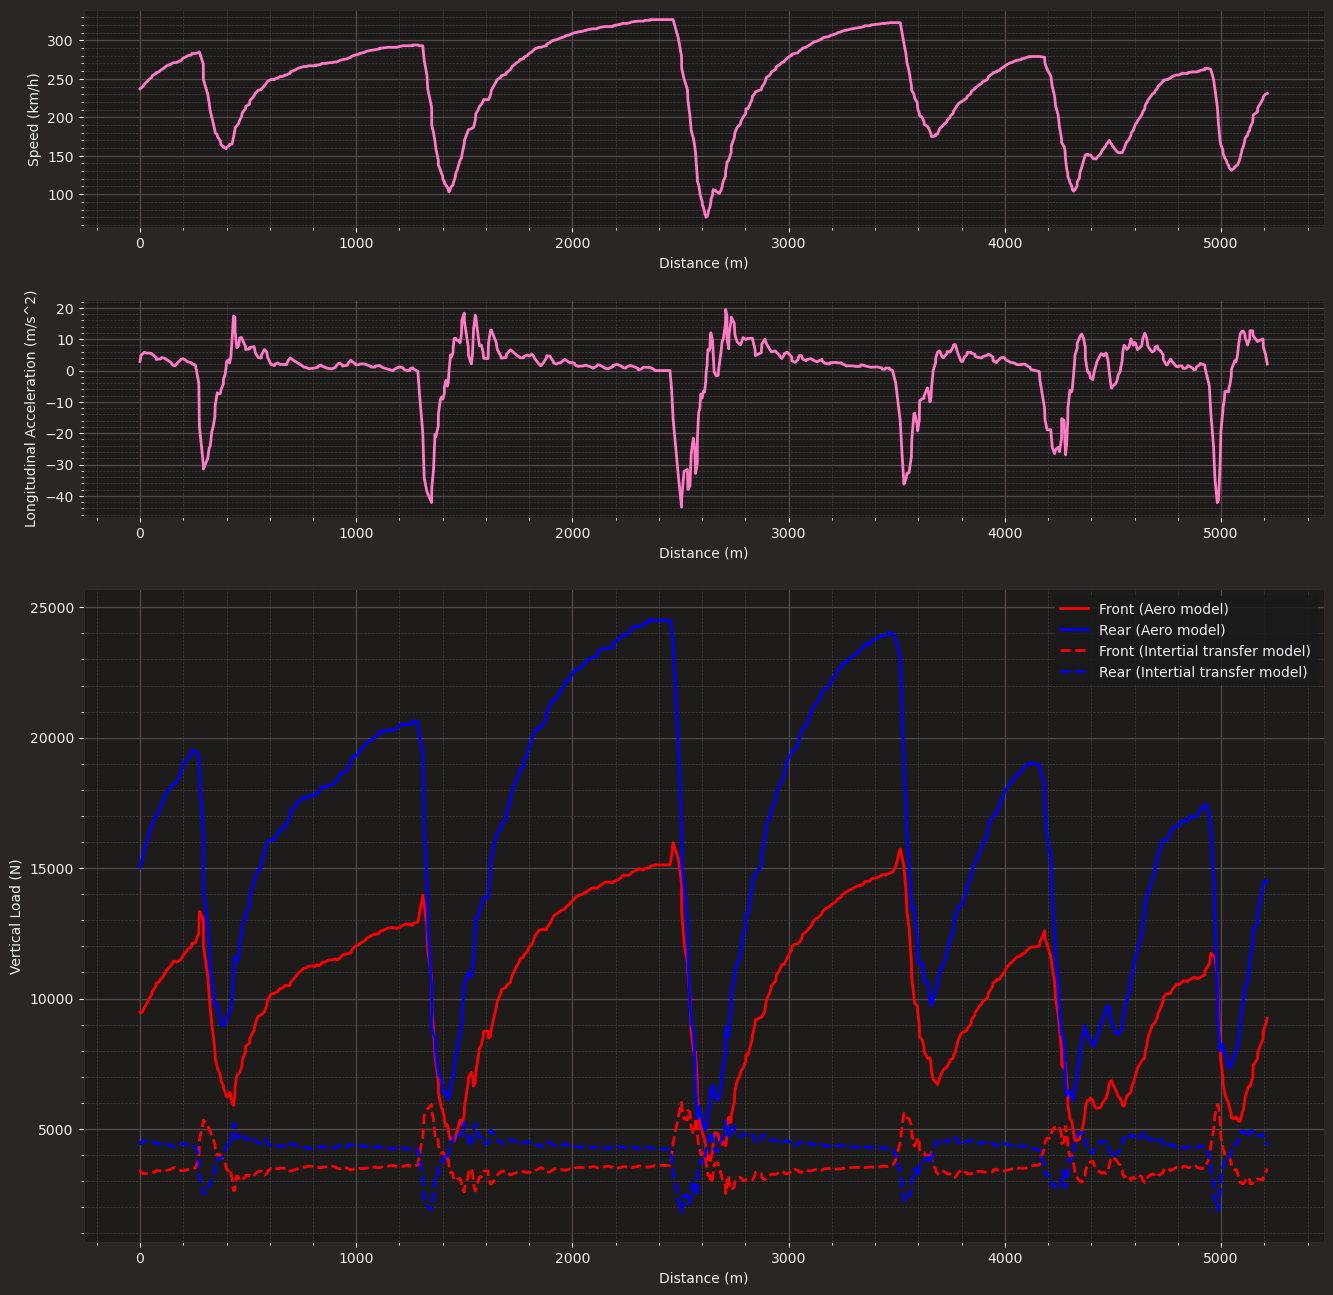

In [13]:
# Plot 3rd model (2nd model for comparison added)
figure, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})

# Speed
axes[0].plot(fl_telemetry["Distance"], fl_telemetry['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

# Acceleration
axes[1].plot(fl_telemetry["Distance"], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

# Vertical load
axes[2].plot(fl_telemetry["Distance"], aero_model_load_front, "r", linewidth = 2, label = "Front (Aero model)")
axes[2].plot(fl_telemetry["Distance"], aero_model_load_rear, "b",  linewidth = 2, label = "Rear (Aero model)")
axes[2].plot(fl_telemetry["Distance"], Intertial_model_load_front, "--r", linewidth = 2, label = "Front (Intertial transfer model)")
axes[2].plot(fl_telemetry["Distance"], Intertial_model_load_rear, "--b",  linewidth = 2, label = "Rear (Intertial transfer model)")
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [14]:
# Build complete function for tyre load computation
def compute_tyre_load(v, ax_smooth, m, weight_front_fraction, cog_height, wheelbase, CdA, ClA, drag_height, fraction_downforce_front):

    # Parameters from 1st model (Static weight only)
    static_weight_total = m * g
    
    static_weight_front = static_weight_total * weight_front_fraction
    static_weight_rear = static_weight_total - static_weight_front

    static_model_load_front = [static_weight_front] * len(v)
    static_model_load_rear = [static_weight_rear] * len(v)

    # Parameters from 2nd model (Intertial load transfer added)
    delta_load_intertia = - cog_height / wheelbase * m * ax_smooth # delta < 0 -> Positive acceleration (Load shifts to the rear)

    Intertial_model_load_front = static_weight_front + delta_load_intertia
    Intertial_model_load_rear = static_weight_rear - delta_load_intertia
    
    # Parameters from 3rd model (Drag and downforce added)
    drag = 0.5 * CdA * air_density * np.square(v)
    delta_load_drag = - drag_height / wheelbase * drag # Always negative: Drag shifts load from front to rear

    downforce = 0.5 * ClA * air_density * np.square(v)
    downforce_front = fraction_downforce_front * downforce
    downforce_rear = (1 - fraction_downforce_front) * downforce

    aero_model_load_front = Intertial_model_load_front + downforce_front + delta_load_drag
    aero_model_load_rear = Intertial_model_load_rear + downforce_rear - delta_load_drag

    return(aero_model_load_front, aero_model_load_rear)

In [15]:
# Select 2nd driver for comparison (Not meaningful, only for experimental reasons)
driver_comp = "HAM"
fl_comp = session.laps.pick_driver(driver_comp).pick_fastest()
fl_telemetry_comp = fl_comp.get_telemetry().add_distance()

# Compute speed and time
v_comp = fl_telemetry_comp["Speed"] / 3.6
t_comp = fl_telemetry_comp["Time"] / np.timedelta64(1, "s") # Change format (date -> number)

# Compute longitudinal acceleration
ax_comp = np.gradient(v_comp) / np.gradient(t_comp) # Take variation of both speed and time
ax_smooth_comp = np.convolve(ax_comp, np.ones(3,) / 3, mode = "same") # Smooth accerlation

In [16]:
# Calculate tyre loads for both drivers using the 3rd model
aero_model_load_front_VER, aero_model_load_rear_VER = compute_tyre_load(v, ax_smooth, m, weight_front_fraction, cog_height, wheelbase, CdA, ClA, drag_height, fraction_downforce_front)
aero_model_load_front_comp, aero_model_load_rear_comp = compute_tyre_load(v_comp, ax_smooth_comp, m, weight_front_fraction, cog_height, wheelbase, CdA, ClA, drag_height, fraction_downforce_front)

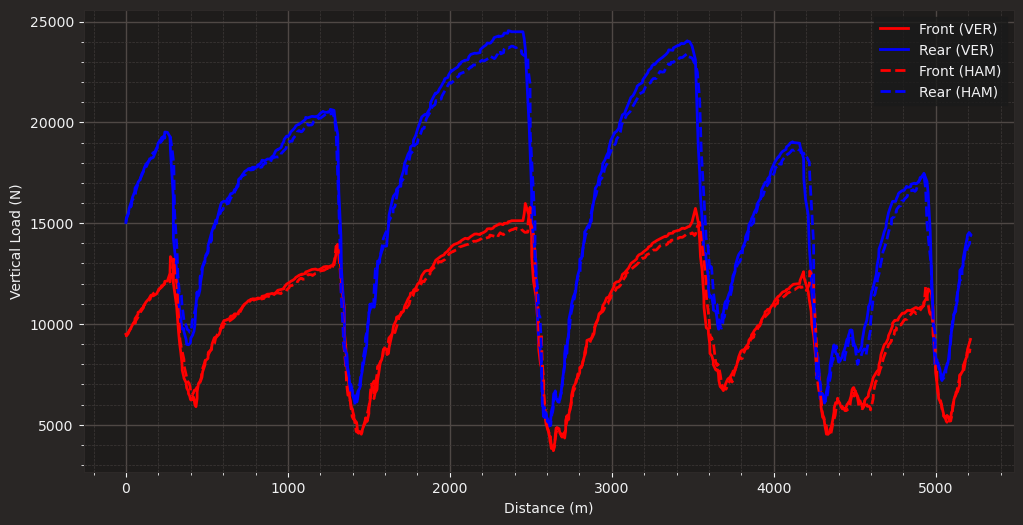

In [17]:
# Plot aero model for both drivers
figure, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(fl_telemetry["Distance"], aero_model_load_front_VER, "r", linewidth = 2, label = "Front (VER)")
ax.plot(fl_telemetry["Distance"], aero_model_load_rear_VER, "b",  linewidth = 2, label = "Rear (VER)")
ax.plot(fl_telemetry_comp["Distance"], aero_model_load_front_comp, "--r", linewidth = 2, label = "Front (" + driver_comp + ")")
ax.plot(fl_telemetry_comp["Distance"], aero_model_load_rear_comp, "--b",  linewidth = 2, label = "Rear (" + driver_comp + ")")
ax.set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
ax.legend()